<a href="https://colab.research.google.com/github/rowanmacy/text-classifier/blob/main/Problem_2_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os
import textwrap

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

from scipy.stats import uniform

In [2]:
# TODOs

In [2]:
# Clone repo
!rm -rf /content/text-classifier  # clear any existing clone
!git clone "https://github.com/rowanmacy/text-classifier/"  # clone repo

Cloning into 'text-classifier'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 75 (delta 19), reused 30 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (75/75), 31.50 MiB | 11.90 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [3]:
# Check repo contents
!ls /content/text-classifier/starter_code/data_readinglevel/

x_test_BERT_embeddings.npz  x_train_BERT_embeddings.npz  y_train.csv
x_test.csv		    x_train.csv


## Read in data

In [4]:
# Read in training data
x_dev = np.array(np.load("/content/text-classifier/starter_code/data_readinglevel/x_train_BERT_embeddings.npz")['arr_0'])
y_dev = pd.read_csv("/content/text-classifier/starter_code/data_readinglevel/y_train.csv")
x_test  = np.array(np.load("/content/text-classifier/starter_code/data_readinglevel/x_test_BERT_embeddings.npz")['arr_0'])

In [5]:
# Convert coarse label into binary classification
y_dev['Class'] = (y_dev['Coarse Label'] == 'Key Stage 4-5').astype(int)
y_dev = y_dev['Class']

## Pre-defined split for proxy test set (validation)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(x_dev, y_dev, test_size=0.2, random_state=42, shuffle=True)

## Set up pipeline

In [7]:
# Define pipeline for preprocessing and classifier
problem_1_pipeline = Pipeline([
     ('problem_2_model', LogisticRegression(max_iter=1500, random_state=101, penalty='l1')),
])

## Create RandomizedSearchCV

In [8]:
# Define hyperparameter grid to search and scoring metric
distributions = dict()

# Model parameters
distributions['problem_2_model__C'] = np.logspace(-6, 6, 1000)
distributions['problem_2_model__solver'] = ['lbfgs', 'saga', 'liblinear']
distributions['problem_2_model__penalty'] = ['l1', 'l2']

# Preprocessor parameters
scoring_metric = 'roc_auc'

In [10]:
# Define RandomizedSearchCV and fit to training data
random_searcher = RandomizedSearchCV(
    problem_1_pipeline,
    distributions,
    n_iter=10,  # increases number of parameter combinations tried
    scoring=scoring_metric,
    cv=KFold(n_splits=5, shuffle=True), # Always good to shuffle
    refit=True, # Automatically retrain the best-performing model on all available data
    verbose = 1,
    random_state=101,
    error_score = 'raise')

In [11]:
# Fit random_searcher object to training data
random_searcher.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                   error_score='raise',
                   estimator=Pipeline(steps=[('problem_2_model',
                                              LogisticRegression(max_iter=1500,
                                                                 penalty='l1',
                                                                 random_state=101))]),
                   param_distributions={'problem_2_model__C': array([1.00000000e-06, 1.02804473e-06, 1.05687597e-06, 1.08651577e-06,
       1.11698682e-06, 1.14831241e-06, 1.180516...
       6.60419396e+05, 6.78940681e+05, 6.97981391e+05, 7.17556092e+05,
       7.37679760e+05, 7.58367791e+05, 7.79636013e+05, 8.01500696e+05,
       8.23978568e+05, 8.47086827e+05, 8.70843150e+05, 8.95265713e+05,
       9.20373200e+05, 9.46184819e+05, 9.72720319e+05, 1.00000000e+06]),
                                        'problem_2_model__penalty': ['l1',
                                                                     'l2'],
                                        'problem_2_model__solver': ['lbfgs',
                                                                    'saga',
                                                                    'liblinear']},
                   random_state=101, scoring='roc_auc', verbose=1)

In [12]:
# Print result of search
problem_1_hyp_results = pd.DataFrame(random_searcher.cv_results_).copy()
param_keys = ['param_'+str(key) for key in random_searcher.best_params_.keys()]

# Rearrange row order
problem_1_hyp_results.sort_values(param_keys, inplace=True)

# Visualize
problem_1_hyp_results[param_keys + ['mean_test_score', 'rank_test_score']]

,param_problem_2_model__solver,param_problem_2_model__penalty,param_problem_2_model__C,mean_test_score,rank_test_score
0,lbfgs,l2,8354.528058,0.744495,9
8,liblinear,l1,224569.799554,0.744820,8
4,liblinear,l2,0.000015,0.759648,3
2,liblinear,l2,0.000518,0.775681,2
1,liblinear,l2,0.001222,0.780820,1
6,liblinear,l2,143.270295,0.745319,7
7,saga,l1,0.000088,0.500000,10
5,saga,l1,223.022330,0.745845,4
3,saga,l1,250841.505928,0.745626,5
9,saga,l2,340041.193270,0.745626,5


In [13]:
# Capture best hyperparameters
problem_1_params = random_searcher.best_params_

for param, value in problem_1_params.items():
  print(param, ':', value)

problem_2_model__solver : liblinear
problem_2_model__penalty : l2
problem_2_model__C : 0.0012220446866314887


## Make predictions and plot ROC curve

In [14]:
# Evaluate performance on training and validation data
yhat_tr = random_searcher.predict_proba(X_train)[:,1]
yhat_val = random_searcher.predict_proba(X_val)[:,1]

# Calculate AUROC for training and validation predictions
roc_auc_tr = roc_auc_score(y_train, yhat_tr)
roc_auc_val = roc_auc_score(y_val, yhat_val)
print('Training score:', round(roc_auc_tr, 3))
print('Validation score:', round(roc_auc_val, 3))

Training score: 0.791
Validation score: 0.791


In [15]:
# Print confusion matrices at 50% threshold
print('Training CF:\n', confusion_matrix(y_train, yhat_tr >= 0.5))
print('\nValidation CF:\n', confusion_matrix(y_val, yhat_val >= 0.5))

Training CF:
 [[1361  649]
 [ 618 1817]]

Validation CF:
 [[332 167]
 [152 461]]


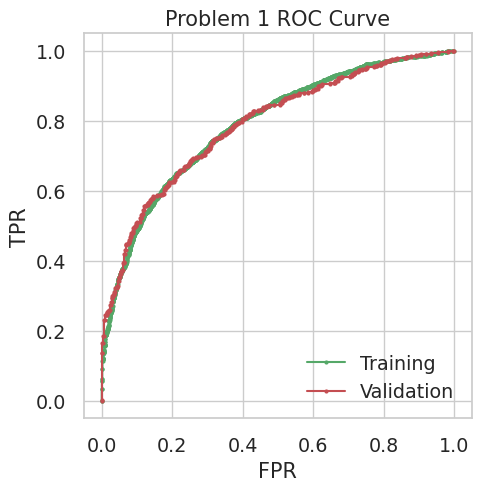

In [16]:
# Print ROC curves
tr_fpr, tr_tpr, tr_thresholds = roc_curve(y_train, yhat_tr)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, yhat_val)

plt.figure(figsize=(5,5))
plt.plot(tr_fpr, tr_tpr, 'g.-', label='Training')
plt.plot(val_fpr, val_tpr, 'r.-', label='Validation')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Problem 1 ROC Curve')
plt.legend(loc='lower right')

## Save results to file

In [17]:
# Save parameters to text file
with open('parameter_iterations.txt', "a") as f:
  for param, value in problem_1_params.items():
    f.write('\n' + str(param) + ': ' + str(value))
  f.write('\n\nTraining score: ' + str(round(roc_auc_tr, 3)))
  f.write('\n\n')

In [18]:
# Make predictions on test data
yhat_test = random_searcher.predict_proba(x_test)

In [45]:
# Delete previous file
os.remove('yproba1_test.txt')

# Save results to .txt file
file = open('yproba1_test.txt', "x")

with open('yproba1_test.txt', "w") as f:
    f.write('\n'.join(str(v) for v in yhat_test[:, 1]))